In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

# import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

In [2]:
tweets = pd.read_csv("../data/cyberbullying_tweets.csv")

## EDA

In [3]:
print(tweets.shape)

(47692, 2)


In [4]:
tweets.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [5]:
tweets.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

<AxesSubplot:ylabel='cyberbullying_type'>

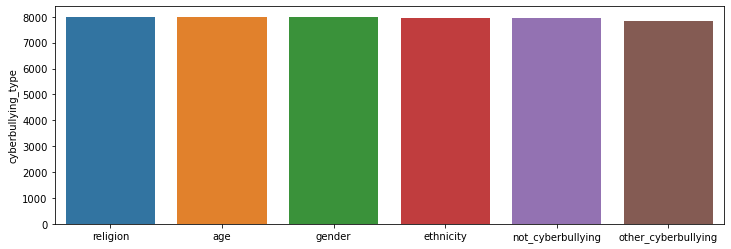

In [6]:
plt.figure(figsize=(12,4))
sns.barplot(x=tweets['cyberbullying_type'].value_counts().index, y=tweets['cyberbullying_type'].value_counts())

## Data Preprocessing

In [14]:
def normalize_accent(string):
    string = string.replace('á', 'a')
    string = string.replace('à', 'a')
    string = string.replace('â', 'a')

    string = string.replace('é', 'e')
    string = string.replace('è', 'e')
    string = string.replace('ê', 'e')
    string = string.replace('ë', 'e')

    string = string.replace('î', 'i')
    string = string.replace('ï', 'i')

    string = string.replace('ö', 'o')
    string = string.replace('ô', 'o')
    string = string.replace('ò', 'o')
    string = string.replace('ó', 'o')

    string = string.replace('ù', 'u')
    string = string.replace('û', 'u')
    string = string.replace('ü', 'u')

    string = string.replace('ç', 'c')
    
    return string

In [15]:
STOPWORDS = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

In [16]:
def clean_tweet(text):
    # Remove Hashtag, Mention, https, www.asdf, zxcv.com
    pattern = re.compile(r"(#[A-Za-z0-9]+|@[A-Za-z0-9]+|https?://\S+|www\.\S+|\S+\.[a-z]+|RT @)")
    text = pattern.sub('', str(text))
    text = " ".join(text.split())
    
    # Make all text lowercase
    text = text.lower()
    
    # Replace accented letters
    text = normalize_accent(text)

    # Lemmatize word and remove stopwords
    text = " ".join([lemma.lemmatize(word) for word in str(text).split() if word.isalpha() and word not in STOPWORDS])

    # Remove Punctuation
    text = re.sub(r'[^\w\s]', '', text)

    return text

In [19]:
tweets['clean_tweet'] = tweets['tweet_text']
tweets['clean_tweet'] = tweets['clean_tweet'].apply(lambda text: clean_tweet(text))
tweets.head()

,tweet_text,cyberbullying_type,clean_tweet
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word food
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy red velvet
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,thanks head concerned another angry dude
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish like


In [20]:
tweets.isnull().sum()

tweet_text            0
cyberbullying_type    0
clean_tweet           0
dtype: int64

In [21]:
tweets.to_csv("../data/cleaned_cyberbullying_tweets.csv")